Beata Sirowy

# Bayes therorem in practice: estimating proportions

Based on: Downey, A. (2021) _Think Bayes_

### The Euro problem

In _Information Theory, Inference, and Learning Algorithms_, David MacKay
poses this problem:

_A statistical statement appeared in The Guardian on Friday January 4, 2002:
When spun on edge 250 times, a Belgian one-euro coin came up heads 140
times and tails 110. “It looks very suspicious to me,” said Barry Blight, a
statistics lecturer at the London School of Economics. “If the coin were
unbiased, the chance of getting a result as extreme as that would be less than
7%.”
But do these data give evidence that the coin is biased rather than fair?_


To answer that question, we’ll proceed in two steps. First we’ll use the binomial
distribution to see where that 7% came from; then we’ll use Bayes’s theorem to
estimate the probability that this coin comes up heads.

### The Binomial Distribution

Suppose the probability of heads is P and we spin the coin N
times. The probability that we get a total K of heads is given by the binomial
distribution:

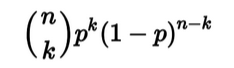

for any value of K from 0 to N , including both. 

- The term is the binomial
coefficient, usually pronounced “n choose k”.
We could evaluate this expression ourselves, but we can also use the SciPy
function binom.pmf. 

For example, if  
- we flip a coin n=2 times and 
- the
probability of heads is p=0.5, 
- here’s the probability of getting k=1 heads:

We could evaluate this expression ourselves, but we can also use the __SciPy
function binom.pmf__. For example, if we flip a coin n=2 times and the
probability of heads is p=0.5, here’s the probability of getting k=1 heads:

In [3]:
from scipy.stats import binom

n = 2
p = 0.5
k = 1

binom.pmf(k, n, p)

np.float64(0.5000000000000002)

In [6]:


n = 250
p = 0.5
k = 140

binom.pmf(k, n, p)

np.float64(0.008357181724918188)

Instead of providing a single value for k, we can also call binom.pmf with an
array of values:

In [13]:
import numpy as np

n = 5
p = 0.5
k = 1


ks = np.arange(n+1)
ps = binom.pmf(ks, n, p)

ps


array([0.03125, 0.15625, 0.3125 , 0.3125 , 0.15625, 0.03125])

The result is a NumPy array with the probability of 0, 1, or 2 heads. If we put these probabilities in a Pmf, the result is the distribution of k for the given
values of n and p.
Here’s what it looks like:

In [16]:
from empiricaldist import Pmf
pmf_k = Pmf(ps, ks)
pmf_k

,probs
0,0.03125
1,0.15625
2,0.31250
3,0.31250
4,0.15625
5,0.03125


The following function computes the binomial distribution for given values of n
and p and returns a Pmf that represents the result:

In [18]:
def make_binomial(n, p): #Make a binomial Pmf
    ks = np.arange(n+1)
    ps = binom.pmf(ks, n, p)
    return Pmf(ps, ks)

make_binomial(5, 0.5)

,probs
0,0.03125
1,0.15625
2,0.31250
3,0.31250
4,0.15625
5,0.03125


Here’s what it looks like with n=250 and p=0.5:

In [20]:
make_binomial(n=250, p=0.5)

,probs
0,5.527148e-76
1,1.381787e-73
2,1.720325e-71
3,1.422135e-69
4,8.781685e-68
...,...
246,8.781685e-68
247,1.422135e-69
248,1.720325e-71
249,1.381787e-73


The most likely quantity in this distribution is 125:

In [21]:
pmf_k = make_binomial(n=250, p=0.5)
pmf_k.max_prob()

np.int64(125)

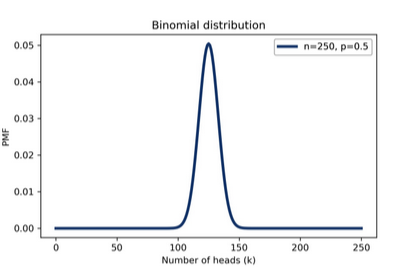

But even though it is the most likely quantity, the probability that we get exactly
125 heads is only about 5%:

In [22]:

pmf_k[125]

np.float64(0.05041221314730967)

In [23]:
pmf_k[140]

np.float64(0.008357181724918188)

We can get the same result directly with the binom.pmf function  

In [24]:
n = 250
p = 0.5
k = 140

binom.pmf(k, n, p)

np.float64(0.008357181724918188)

In the article MacKay quotes, the statistician says, _“If the coin were unbiased the
chance of getting a result as extreme as that would be less than 7%.”_

We can use the binomial distribution to check his math. 
- The following function
takes a PMF and computes __the total probability of quantities greater than or
equal to threshold__:

In [28]:
def prob_ge(pmf, threshold): # Probability of quantities greater than threshold
    ge = (pmf.qs >= threshold)
    total = pmf[ge].sum()
    return total

 The Pmf object has two attributes:
- qs contains the quantities in the distribution;
- ps contains the corresponding probabilities.


Here’s the probability of getting 140 heads or more:

In [29]:
prob_ge(pmf_k, 140)

np.float64(0.03321057562002166)

Pmf provides a method that does the same computation:

In [30]:
pmf_k.prob_ge(140)

np.float64(0.03321057562002166)

The result is about 3.3%, which is less than the quoted 7%. The reason for the
difference is that the statistician includes all outcomes “as extreme as” 140,
which includes outcomes less than or equal to 110.

To see where that comes from, recall that the expected number of heads is 125. If
we get 140, we’ve exceeded that expectation by 15. And if we get 110, we have
come up short by 15.
7% is the sum of both of these “tails”, as shown in the following figure:

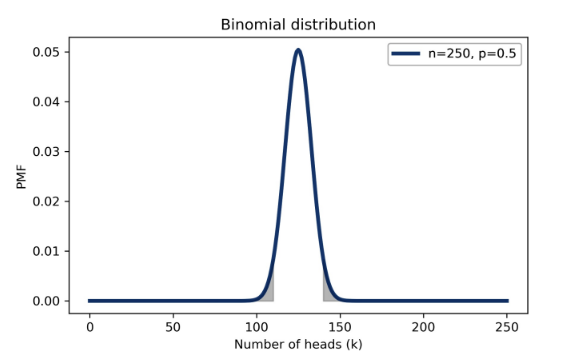

Here’s how we compute the total probability of the left tail:

In [33]:
pmf_k.prob_le(110)

np.float64(0.033210575620021665)

The probability of outcomes less than or equal to 110 is also 3.3%, so the total
probability of outcomes “as extreme” as 140 is 6.6%.
The point of this calculation is that these extreme outcomes are unlikely if the
coin is fair.

### Bayesian Estimation